# Grid Search Experiments for Federated Learning

This notebook automates hyperparameter grid search for different federated learning aggregators (FedAvg, FedAdam, FedAdagrad, FedYogi, FedProx, FedMedian, Scaffold) on the MNIST dataset. It generates commands to test multiple hyperparameter combinations, parses the experimental results, identifies the best-performing configuration for each aggregator, and provides visualizations to compare their performance. The workflow helps determine optimal settings for learning rates, momentum terms, and regularization parameters across different federated optimization algorithms.

In [134]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import re
from typing import Dict, List

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

## 1. Grid Search Commands

**IMPORTANT**: Grid search commands use the `--param` flag with comma-separated values for each parameter.

### FedAdagrad Grid Search
```bash
p2pfl run-variations p2pfl/examples/mnist/mnist.yaml \
  --aggregators FedAdagrad \
  --rounds 40 \
  --seeds 42 \
  --param experiment.dataset.partitioning.strategy=DirichletPartitionStrategy \
  --param experiment.dataset.partitioning.params.alpha=0.1 \
  --param experiment.aggregator.params.eta=0.01,0.1,1.0 \
  --param experiment.aggregator.params.beta_1=0.9,0.99 \
  --param experiment.aggregator.params.tau=1e-9,1e-6,1e-3 \
  --output-dir results_fedadagrad_grid
```

- Final Accuracy: 0.6391 ± 0.1491
  - eta: 1.0
  - beta_1: 0.9
  - tau: 1e-06
  - alpha: 0.1
  
### FedAdam Grid Search
```bash
p2pfl run-variations p2pfl/examples/mnist/mnist.yaml \
  --aggregators FedAdam \
  --rounds 40 \
  --seeds 42 \
  --param experiment.dataset.partitioning.strategy=DirichletPartitionStrategy \
  --param experiment.dataset.partitioning.params.alpha=0.1 \
  --param experiment.aggregator.params.eta=0.01,0.1,1.0 \
  --param experiment.aggregator.params.beta_1=0.9,0.99 \
  --param experiment.aggregator.params.beta_2=0.99,0.999 \
  --param experiment.aggregator.params.tau=1e-6 \
  --output-dir results_fedadam_grid
```

- Final Accuracy: 0.5397 ± 0.2343
  - eta: 1.0
  - beta_1: 0.99
  - beta_2: 0.99
  - tau: 1e-06
  - alpha: 0.1

### FedYogi Grid Search
```bash
p2pfl run-variations p2pfl/examples/mnist/mnist.yaml \
  --aggregators FedYogi \
  --rounds 40 \
  --seeds 42 \
  --param experiment.dataset.partitioning.strategy=DirichletPartitionStrategy \
  --param experiment.dataset.partitioning.params.alpha=0.1 \
  --param experiment.aggregator.params.eta=0.01,0.1 \
  --param experiment.aggregator.params.beta_1=0.9,0.99 \
  --param experiment.aggregator.params.beta_2=0.99,0.999 \
  --param experiment.aggregator.params.tau=1e-6 \
  --output-dir results_fedyogi_grid
```

- Final Accuracy: 0.5095 ± 0.2195
  - eta: 1.0
  - beta_1: 0.99
  - beta_2: 0.999
  - tau: 1e-06
  - alpha: 0.1

### All Non-IID Aggregators
```bash
p2pfl run-variations p2pfl/examples/mnist/mnist.yaml \
  --aggregators FedAvg,FedYogi,FedMedian,Scaffold \
  --rounds 40 \
  --seeds 42 \
  --param experiment.dataset.partitioning.strategy=DirichletPartitionStrategy \
  --param experiment.dataset.partitioning.params.alpha=0.1 \
  --output-dir results_all
```

## 2. Parse Experiment Results

In [135]:
def parse_experiment_dir(exp_dir: Path) -> Dict:
    """Parse a single experiment directory and extract metrics and parameters."""
    result = {}

    # Extract parameters from directory name
    dir_name = exp_dir.name

    # Common parameter patterns
    patterns = {
        'aggregator': r'aggregator_aggregator_(\w+)',
        'eta': r'eta_(\d+\.?\d*(?:e[+-]?\d+)?|\d+p\d+)',
        'beta_1': r'beta_1_([\d\.p]+)',
        'beta_2': r'beta_2_([\d\.p]+)',
        'tau': r'tau_(\d+\.?\d*(?:e[+-]?\d+)?|\d+p\d+)',
        'mu': r'mu_([\d\.p]+)',
        'alpha': r'alpha_([\d\.p]+)',  # Data heterogeneity parameter
    }

    for param, pattern in patterns.items():
        match = re.search(pattern, dir_name)
        if match:
            value = match.group(1)
            if param == 'aggregator':
                result[param] = value
            else:
                # Convert 'p' to '.' and parse as float
                value = value.replace('p', '.')
                result[param] = float(value)
    
    # Load metrics if available
    metrics_file = exp_dir / 'global_metrics.csv'
    if metrics_file.exists():
        metrics_df = pd.read_csv(metrics_file)
        result['metrics'] = metrics_df

        # Calculate final accuracy
        test_metrics = metrics_df[metrics_df['metric'] == 'test_metric']
        if not test_metrics.empty:
            last_round = test_metrics['round'].max()
            final_metrics = test_metrics[test_metrics['round'] == last_round]
            result['final_accuracy'] = final_metrics['value'].mean()
            result['final_accuracy_std'] = final_metrics['value'].std()
            result['best_accuracy'] = test_metrics.groupby('round')['value'].mean().max()

    result['exp_dir'] = exp_dir
    return result


def load_all_experiments(base_dirs: List[str]) -> pd.DataFrame:
    """Load all experiments from multiple result directories."""
    all_experiments = []

    for base_dir in base_dirs:
        base_path = Path(base_dir)
        if not base_path.exists():
            print(f"Warning: {base_path} does not exist")
            continue

        # Find all experiment directories
        for exp_dir in base_path.iterdir():
            if exp_dir.is_dir() and not exp_dir.name.startswith('.'):
                exp_data = parse_experiment_dir(exp_dir)
                if 'final_accuracy' in exp_data:  # Only include if metrics exist
                    all_experiments.append(exp_data)

    if not all_experiments:
        return pd.DataFrame()

    # Convert to DataFrame
    df = pd.DataFrame(all_experiments)
    return df

In [136]:
ls ../../..

CODE_OF_CONDUCT.md                other/
CONTRIBUTING.md                   p2pfl/
Dockerfile                        pyproject.toml
LICENSE.md                        results_all/
README.md                         results_fedadagrad_grid/
SCAFFOLD_IMPLEMENTATION_FIXES.md  results_fedadam_grid/
docs/                             results_fedyogi_grid/
ignore/                           test/
lightning_logs/                   uv.lock
logs/


In [137]:
# Load experiments from all result directories
result_dirs = [
    '../../../results_fedadagrad_grid',
    '../../../results_fedadam_grid', 
    '../../../results_fedyogi_grid',
    '../../../results_all',
]

experiments_df = load_all_experiments(result_dirs)

if not experiments_df.empty:
    print(f"Loaded {len(experiments_df)} experiments\n")
    print("Aggregators found:", experiments_df['aggregator'].unique())
    print("\nSummary statistics:")
    print(experiments_df.groupby('aggregator')['final_accuracy'].describe())
else:
    print("No experiments found. Please run the grid search commands first.")

Loaded 42 experiments

Aggregators found: ['FedAdagrad_aggregator_package_p2pfl' 'FedAdam_aggregator_package_p2pfl'
 'FedYogi_aggregator_package_p2pfl' 'Scaffold_aggregator_package_p2pfl'
 'FedAvg_aggregator_package_p2pfl' 'FedMedian_aggregator_package_p2pfl']

Summary statistics:
                                     count      mean       std       min  \
aggregator                                                                 
FedAdagrad_aggregator_package_p2pfl   18.0  0.367657  0.152809  0.064293   
FedAdam_aggregator_package_p2pfl      12.0  0.283070  0.187149  0.075776   
FedAvg_aggregator_package_p2pfl        1.0  0.707496       NaN  0.707496   
FedMedian_aggregator_package_p2pfl     1.0  0.655432       NaN  0.655432   
FedYogi_aggregator_package_p2pfl       9.0  0.323015  0.175570  0.114655   
Scaffold_aggregator_package_p2pfl      1.0  0.149347       NaN  0.149347   

                                          25%       50%       75%       max  
aggregator                     

## 4. Find Best Configurations

In [138]:
if not experiments_df.empty:
    print("="*80)
    print("BEST CONFIGURATIONS PER AGGREGATOR")
    print("="*80)
    
    best_configs = []
    
    for agg in sorted(experiments_df['aggregator'].unique()):
        agg_df = experiments_df[experiments_df['aggregator'] == agg]
        best_exp = agg_df.loc[agg_df['final_accuracy'].idxmax()]
        
        print(f"\n{agg}:")
        print(f"  Final Accuracy: {best_exp['final_accuracy']:.4f}", end="")
        if 'final_accuracy_std' in best_exp and not pd.isna(best_exp['final_accuracy_std']):
            print(f" ± {best_exp['final_accuracy_std']:.4f}")
        else:
            print()
        
        # Print hyperparameters
        params = ['eta', 'beta_1', 'beta_2', 'tau', 'mu', 'alpha']
        for param in params:
            if param in best_exp and not pd.isna(best_exp[param]):
                print(f"  {param}: {best_exp[param]}")
        
        best_configs.append(best_exp)
    
    best_configs_df = pd.DataFrame(best_configs)
else:
    print("No experiments to analyze.")

BEST CONFIGURATIONS PER AGGREGATOR

FedAdagrad_aggregator_package_p2pfl:
  Final Accuracy: 0.6391 ± 0.1491
  eta: 1.0
  beta_1: 0.9
  tau: 1e-06
  alpha: 0.1

FedAdam_aggregator_package_p2pfl:
  Final Accuracy: 0.5397 ± 0.2343
  eta: 1.0
  beta_1: 0.99
  beta_2: 0.99
  tau: 1e-06
  alpha: 0.1

FedAvg_aggregator_package_p2pfl:
  Final Accuracy: 0.7075 ± 0.1670
  alpha: 0.1

FedMedian_aggregator_package_p2pfl:
  Final Accuracy: 0.6554 ± 0.2023
  alpha: 0.1

FedYogi_aggregator_package_p2pfl:
  Final Accuracy: 0.5815 ± 0.1904
  alpha: 0.1

Scaffold_aggregator_package_p2pfl:
  Final Accuracy: 0.1493 ± 0.1418
  alpha: 0.1


## 5. Accuracy Comparison Plots

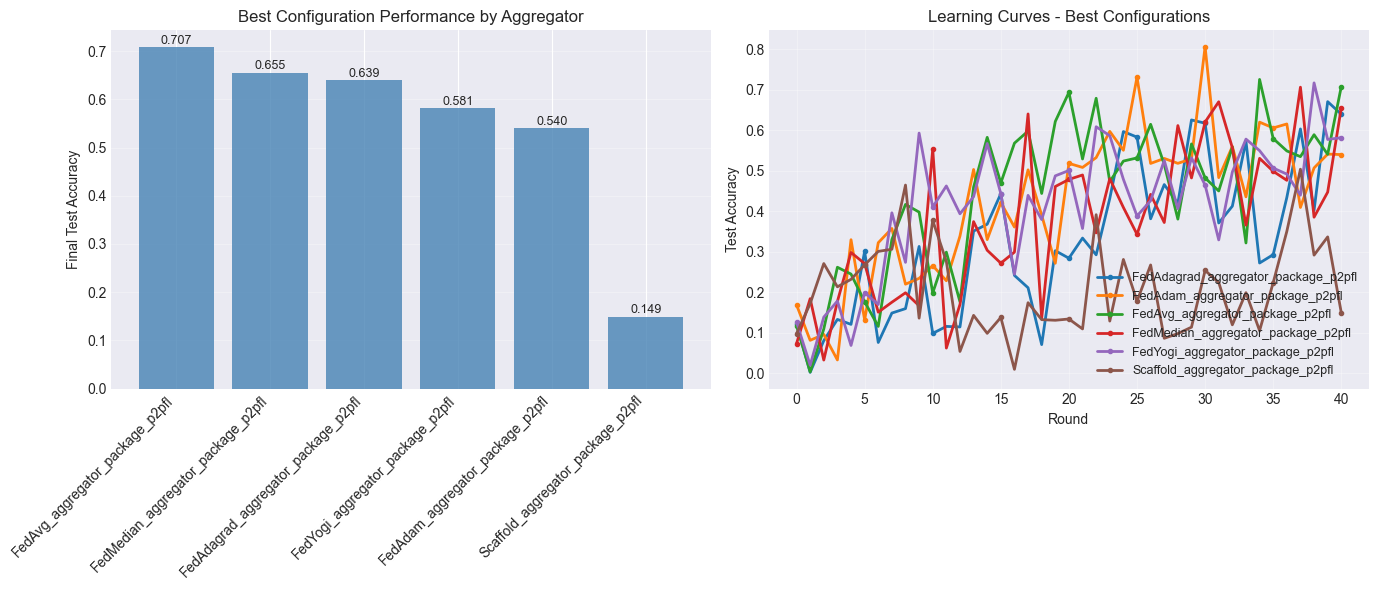

In [139]:
if not experiments_df.empty:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot 1: Best accuracy per aggregator (bar plot)
    ax1 = axes[0]
    best_accs = experiments_df.groupby('aggregator')['final_accuracy'].max().sort_values(ascending=False)
    bars = ax1.bar(range(len(best_accs)), best_accs.values, color='steelblue', alpha=0.8)
    ax1.set_xticks(range(len(best_accs)))
    ax1.set_xticklabels(best_accs.index, rotation=45, ha='right')
    ax1.set_ylabel('Final Test Accuracy')
    ax1.set_title('Best Configuration Performance by Aggregator')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, value in zip(bars, best_accs.values):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                f'{value:.3f}', ha='center', va='bottom', fontsize=9)
    
    # Plot 2: Learning curves for best configurations
    ax2 = axes[1]
    
    for agg in sorted(experiments_df['aggregator'].unique()):
        agg_df = experiments_df[experiments_df['aggregator'] == agg]
        best_exp = agg_df.loc[agg_df['final_accuracy'].idxmax()]
        
        if 'metrics' in best_exp and best_exp['metrics'] is not None:
            metrics = best_exp['metrics']
            test_metrics = metrics[metrics['metric'] == 'test_metric']
            if not test_metrics.empty:
                round_means = test_metrics.groupby('round')['value'].mean()
                ax2.plot(round_means.index, round_means.values, 
                        label=agg, linewidth=2, marker='o', markersize=3, markevery=5)
    
    ax2.set_xlabel('Round')
    ax2.set_ylabel('Test Accuracy')
    ax2.set_title('Learning Curves - Best Configurations')
    ax2.legend(loc='lower right', fontsize=9)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No data available for plotting.")